# Getting Started with `nflows` & `flowtorch` 
https://github.com/bayesiains/nflows

https://flowtorch.ai/users

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as D

import nflows.distributions as distributions
import nflows.transforms as transforms
from nflows.flows.base import Flow

import flowtorch.bijectors as bij
import flowtorch.distributions as dist
import flowtorch.parameters as params

import sys
sys.path.append('../data/')
from toy_data import inf_train_gen

sys.path.append('../flows/')
from nf_flows import construct_maf, construct_nsf
from train import train

## Target distributions for synthetic data

We do not usually know them... but we have access to samples!

We will try to approximate them using the samples!

In [2]:
# Data Dimensions
n = 5000 # Number of datapoints
d = 2 # Dimension of the multivariate distribution

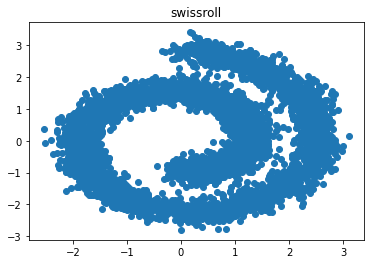

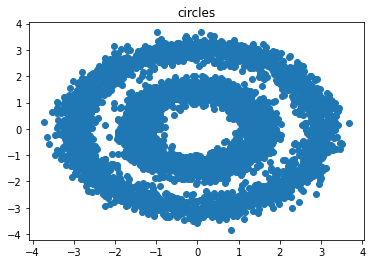

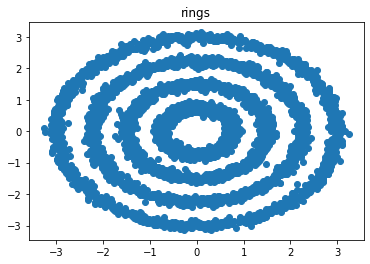

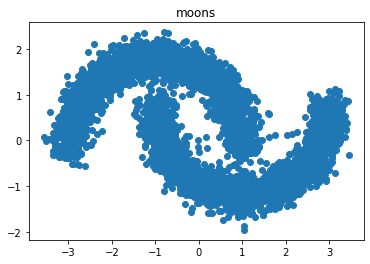

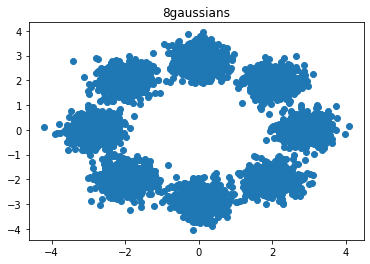

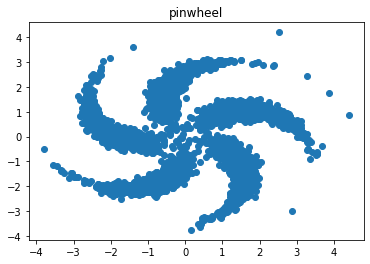

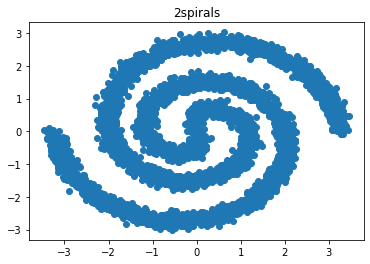

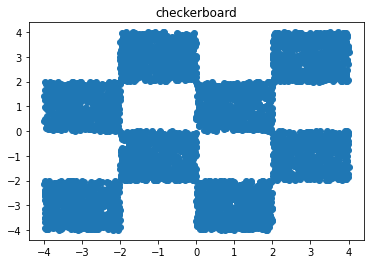

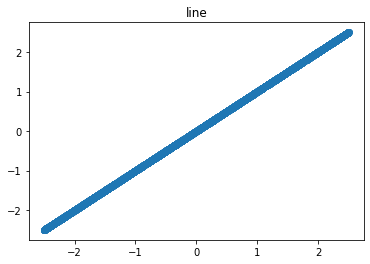

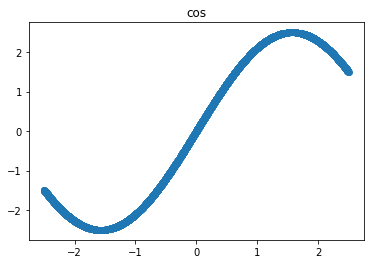

In [3]:
# Toy Data from Gilles Louppe's blog-post `toy_data`
toy_data = ['swissroll', 'circles', 'rings', 'moons', '8gaussians', 'pinwheel', '2spirals', 'checkerboard', 'line', 'cos']

# Plot training samples for each toy data 
for td in toy_data:
    x = inf_train_gen(data=td, batch_size=n)
    plt.scatter(x=x[:,0], y=x[:,1]) 
    plt.title(td)
    plt.show()

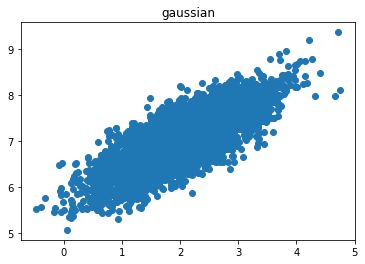

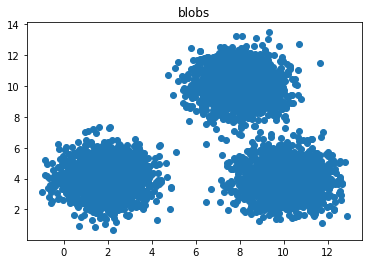

In [4]:
# Gaussian 2D target distributions: Multivartiate Gaussian and GMM Blobs 

# Multivariate Gaussian distribution
means = torch.FloatTensor([2, 7])
# cov_matrix = torch.eye(d)*0.2 + torch.rand((d,d))
cov_matrix = torch.FloatTensor([[0.5, 0.5],[0.3, 0.3]])
multi_normal_dist = D.multivariate_normal.MultivariateNormal(means, cov_matrix) 

# Blobs:2D Gaussian Mixture Model with 3 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(3,))
# gmm_means= torch.randn(3,d)*5
gmm_means = torch.FloatTensor([[2., 4.], [ 8.,  10.], [ 10., 4.]])
# gmm_stds = torch.rand(3,d)
gmm_stds = torch.eye(d) 
#comp = D.Independent(D.Normal(gmm_means, gmm_stds), 1)  # only diagonal covariance matrices...
comp = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_dist_2D = D.mixture_same_family.MixtureSameFamily(mix, comp)

target_dists_2D = {'gaussian': multi_normal_dist, 'blobs': gmm_dist_2D}

# Plot training samples for target dist
for target_dist in target_dists_2D:
    x = target_dists_2D[target_dist].sample((n,)) 
    plt.scatter(x=x[:,0], y=x[:,1]) 
    plt.title(target_dist)
    plt.show()


## `nflows`-library

### MAF on blobs. 

Influence of MAF architecture and training hyperparameters on result:
- number of MAF-layers
- permutation between layers 
- normalizing transform
- number of hidden features
- batch_size and lr

In [5]:
# Target dist & samples: Multivariate Gaussian
target_dist = target_dists_2D['blobs']
x_samples = target_dist.sample((n,))

# Base dist: Only StandardNormal distribution, what about conditional and/or diag ? 
base_dist = distributions.StandardNormal(shape=torch.Size([d]))

# # Linear Flow
# transform = transforms.NaiveLinear(features=d) 
# flow = Flow(transform, base_dist)

# MAF 
maf = construct_maf(features=x_samples, hidden_features=4, standardize_transform=True)


epoch 0:


/Users/julialinhart/Documents/Code/github/NormalizingFlows/notebooks/../flows/eval.py:51: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  xline = torch.linspace(plt_min, plt_max)
/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


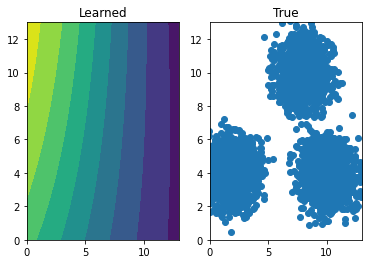

epoch 19:


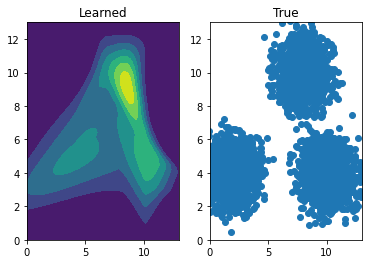

epoch 50:


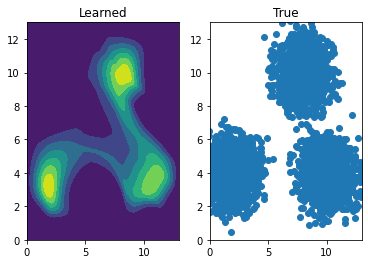

epoch 76:


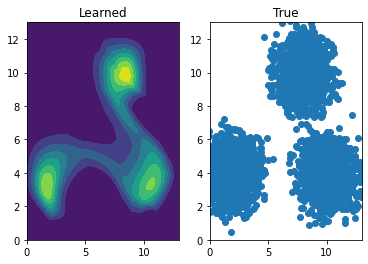

epoch 101:


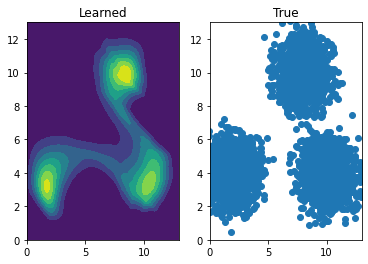

epoch 145:


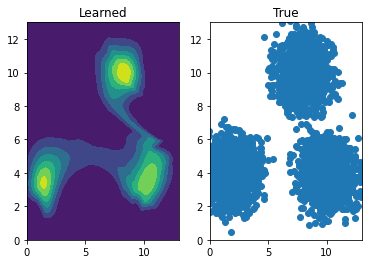

epoch 184:


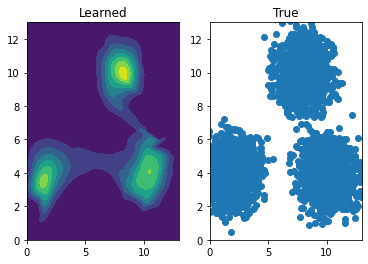

epoch 214:


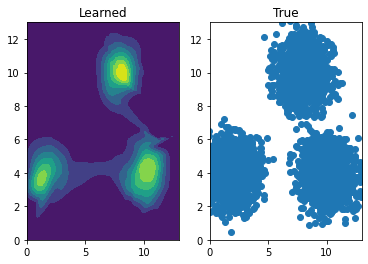

epoch 252:
number of improvements: 149


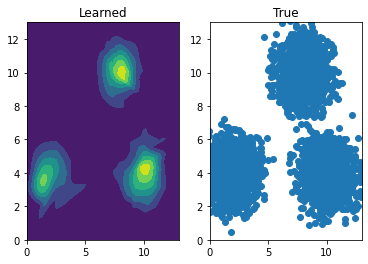

(4.029447555541992, 252)

In [6]:
train(maf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_max=13, validation=True)

#### Flow Architecture:
- `NaiveLinear` works for multivariate gaussian, but not blobs
- `MaskedAffineAutoregressiveTransform` (one layer only) enables more flexible approximations (not only gaussian) and finds support of target, but no independent blobs yet
- `MaskedAffineAutoregressiveTransform` (5 layers but without permutation inbetween) learns more rapidly but the blobs are still connected
- `RandomPermutation` + `MaskedAffineAutoregressiveTransform` (one layer only) seems to learn more disconnected components but not fast enough
- `ReversePermutation` + `MaskedAffineAutoregressiveTransform` (one layer only) does not work (not even the support is right)
- `RandomPermutation` + `MaskedAffineAutoregressiveTransform` (5 layers) blobs are now rather well approximated but still a little connected and the 3 means have not same weight
- `ReversePermutation` + `MaskedAffineAutoregressiveTransform` (5 layers) blobs are ratther well approximated (and disconnected) and means have more or less the same weights
- `standardizing_transform` creates more beautiful blobs with less training samples, makes convergence faster (after 1500-2000 vs. 5000 epochs with 5000 training samples)
- `hidden_features` number? defines depth of the flow, makes training slower but convergence faster if enough training samples, too many harm the approximation if not enough training samples (too many fluctuations..)! 4 here, 50 in `sbi`

#### Training Hyperparameters:
- `batch_size` super important (10 too low -  training too long,  50 is good, or even 500 for 5000 training samples!)
- `lr` (if too low 1e-3, gets stuck in local minima and means not equally weihted, if too high 1e-2 no convergence)

#### Comments:
- same architecture as `MaskedAutoregressiveFlow` from `nflows.flows` 
- in `sbi.neural_nets.flow.build_maf` they use the `standardizing_transform` followed by 5 layers of a `RandomPermutation` **after** the `MaskedAffineAutoregressiveTransform` and 50 hidden features.
- the best one seems to be the one from nflows, but without to many `hidden_features` (4) and `standerdizing_transform`.
- the number of samples highly impacts the result (faster and more stable convergence - after 1500-2000 epochs, less overfit, more beautiful shapes - real circle like blobs)

#### Questions:
- Only `StandardNormal` base distribution, what about conditional and/or diag ? 
- difference between `RandomPermutation` and `ReversePermutation`?
- why permutation before autoregressive layer and not after? 
- how to get same weight on all blobs? for now just longer training and more samples! 

#### TODO:
- multimodal base_dist 
- other targets 


### NSF on blobs. 

Influence of NSF architecture and training hyperparameters on result:


epoch 0:


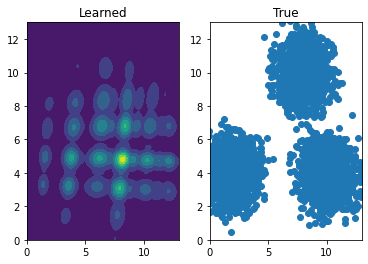

epoch 32:
number of improvements: 9


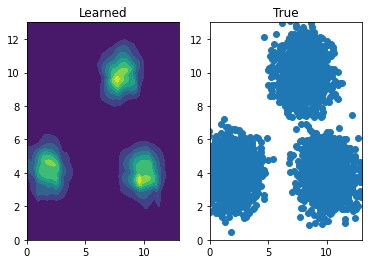

(3.99298087755839, 32)

In [7]:
# NSF 
nsf = construct_nsf(x_samples, hidden_features=50)
train(nsf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_max=13, validation=True)

#### Comments:
- nsf is better than maf for fewer samples 
- training is long! convergence is fast.
- n_samples is important, nsf tends to overfit! very expressive, but needs to be smoothened. 
- color scale not as wanted - renormalize? 

## Moons 

In [8]:
n = 5000

x_samples = inf_train_gen(data='moons', batch_size=n)
x_samples = torch.FloatTensor(x_samples)

maf = construct_maf(x_samples, hidden_features=50)

epoch 0:


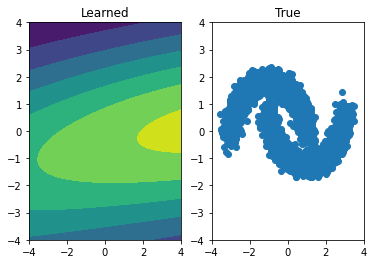

epoch 26:


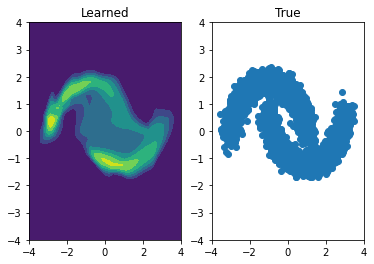

epoch 127:
number of improvements: 37


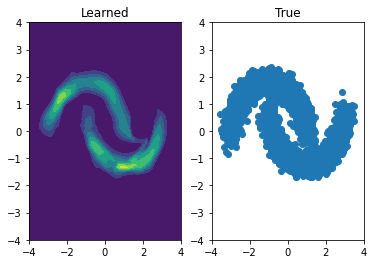

(2.463109254837036, 127)

In [9]:
train(maf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

epoch 0:


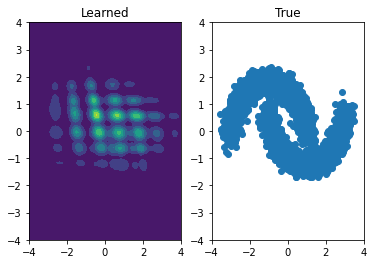

epoch 54:
number of improvements: 15


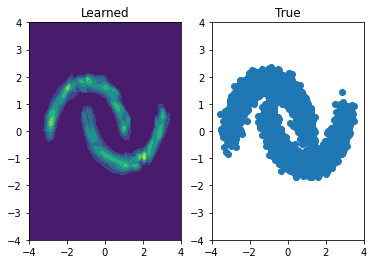

(2.4582788149515786, 54)

In [10]:
nsf = construct_nsf(x_samples, hidden_features=50)
train(nsf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

#### Comments: 
- shape of moons is more accurate with more hidden features 
- nsf needs to be smoothened (non connected components for small number of training samples)
- for enough samples, maf is better because more smooth


## 2spirals
 

In [13]:
n = 5000

x_samples = inf_train_gen(data='2spirals', batch_size=n)
x_samples = torch.FloatTensor(x_samples)

maf = construct_maf(x_samples, hidden_features=50)

epoch 0:


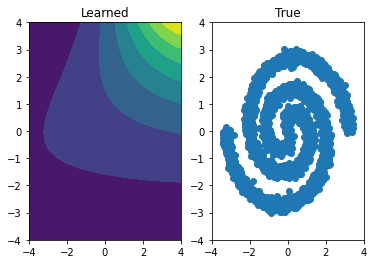

epoch 66:
number of improvements: 17


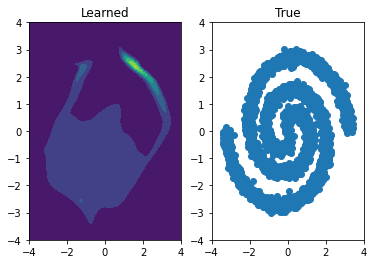

(3.2916738986968994, 66)

In [15]:
train(maf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

epoch 0:


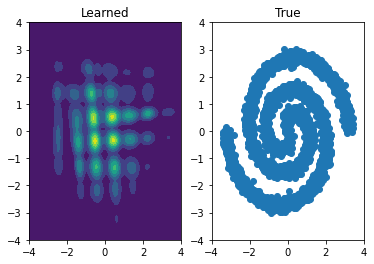

epoch 40:


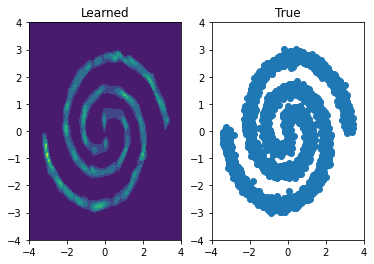

epoch 77:
number of improvements: 22


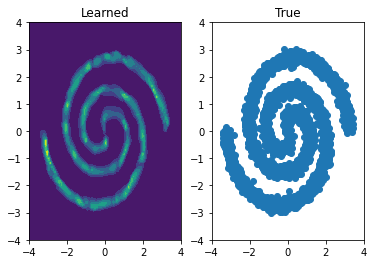

(2.7272053559621177, 77)

In [18]:
nsf = construct_nsf(x_samples, hidden_features=50)
train(nsf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

#### Comments: 
- nsf more expressive for this kind of complex data distribution
- nsf seems to be smoother at the beginning of training: overfitting? 

## Checkerboard

In [19]:
n = 5000

x_samples = inf_train_gen(data='checkerboard', batch_size=n)
x_samples = torch.FloatTensor(x_samples)

epoch 0:


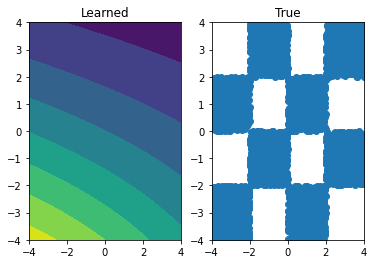

epoch 29:


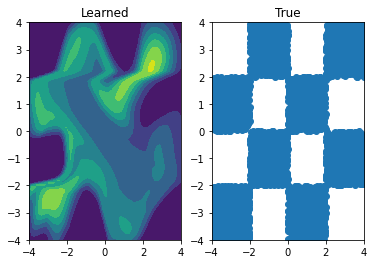

epoch 123:
number of improvements: 32


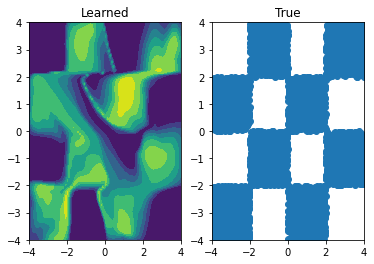

(3.7779976526896157, 123)

In [20]:
maf = construct_maf(x_samples, hidden_features=50)
train(maf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

epoch 0:


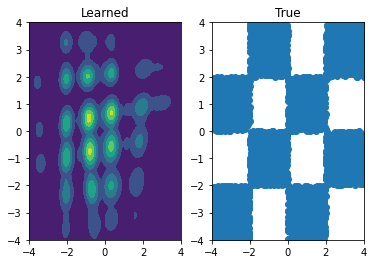

epoch 51:


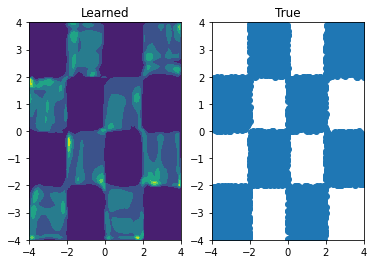

epoch 121:
number of improvements: 27


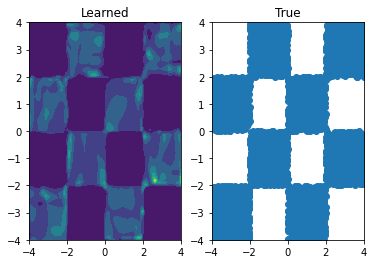

(3.5739083290100098, 121)

In [21]:
nsf = construct_nsf(x_samples, hidden_features=50)
train(nsf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

#### Comments: 
- nsf better shape (espescially for fewer training samples) but colors fade with longer training
- maf not working if number of training samples is too low 

## `flowtorch`-library



### Base distributions and transformations

In [44]:
# Define base distribution 
normal_bs = D.MultivariateNormal(torch.zeros(d), torch.eye(d))

mix_bs = D.Categorical(torch.ones(3,))
gmm_means = torch.zeros(3,d)
gmm_stds = torch.eye(d) 
comp_bs = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_bs = D.mixture_same_family.MixtureSameFamily(mix_bs, comp_bs)

base_dists = {'normal': normal_bs, 'mixture_normal': gmm_bs}

# Define transformations
parameters = params.DenseAutoregressive(hidden_dims=(32,))
transformations = {'affine': bij.Affine(), 'affineAutoreg': bij.AffineAutoregressive(parameters)}

In [39]:
def plot_2d_pdf_contours(target_dist, x_samples, flow, title=None, n=500, gaussian=False):
    x_true = target_dist.sample((n,))  # Sample from groundtruth
    x_learned = flow.sample((n,)).detach().numpy()  # Sample from learned
    
    plt.scatter(x=x_samples[:,0], y=x_samples[:,1]) # Plot training samples
    sns.kdeplot(x=x_true[:,0], y=x_true[:,1])  # Plot true distribution
    sns.kdeplot(x=x_learned[:,0], y=x_learned[:,1])  # Plot learned distribution
    plt.legend(['Samples', 'True', 'Learned'], loc="upper right")

    if gaussian:
        means_learned = np.mean(x_learned, axis=0)  # Learned mean
        plt.scatter(x=target_dist.mean[0], y=target_dist.mean[1], color='cyan')
        plt.scatter(x=means_learned[0], y=means_learned[1], color='magenta')
    
    plt.title(title)
    plt.show()

### Multivariate Gaussian Target

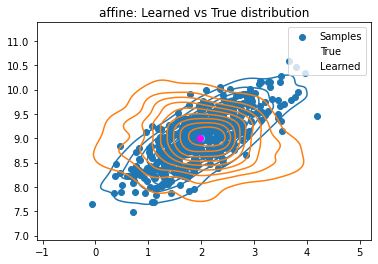

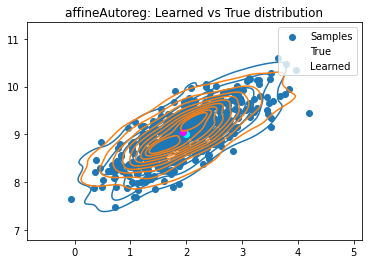

In [41]:
# Generate training data samples
target_dist = target_dists_2D['gaussian'] # We do not usually know this...
x_samples = target_dist.sample((n,))  # ...but all we have are these samples.

for trans in list(transformations.keys()):
    # Construct Flow
    flow = dist.Flow(base_dists['normal'], transformations[trans])
    # Train Flow 
    train(flow, x_samples, num_epochs=500)
    #Evaluate learned pdf
    plot_2d_pdf_contours(target_dist, x_samples, flow, title=trans+': Learned vs True distribution', gaussian=True)

### Blobs/GMM Target

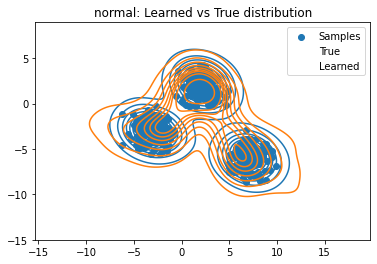

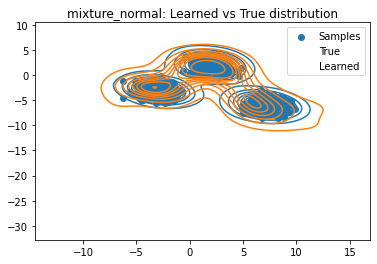

In [42]:
# Generate training data samples
target_dist = target_dists_2D['blobs'] # We do not usually know this...
x_samples = target_dist.sample((n,))  # ...but all we have are these samples.

for base_dist in list(base_dists.keys()):
    # Construct Flow
    flow = dist.Flow(base_dists[base_dist], transformations['affineAutoreg'])
    # Train Flow 
    train(flow, x_samples, num_epochs=2000)
    #Evaluate learned pdf
    plot_2d_pdf_contours(target_dist, x_samples, flow, title=base_dist+': Learned vs True distribution')

TODO: 

- multimodal for affine (not autoreg)
- compose autoreg and perm
- several layers - builds maf 

- other 1D trans? spline?
- coupling layers, splines

- other transformations? combine spline with affine?


Questions:
- autoregressive parameters ? 
- MADE vs MaskedAutoregAffine + perm in nflows 
- How does spline work?
- en 1D comment changer? quand ustilise des nsf et pq?

Influence of:
- permutations between MADEs: without cannot decouple modes - result are connected non equally weighted blobs. They enable to combine different affine transformations on different coordinates which in turn enables to capture the modes.
- number of layers : one not enough to capture the 3 modes of the true target (gets stuck), the more layers, the better the blobs-approximation and the less iterations needed 

TODO: 
look at 1D 